In [2]:
import sys

!{sys.executable} -m pip install openpyxl

  Using cached openpyxl-3.0.9-py2.py3-none-any.whl (242 kB)


In [3]:
from openpyxl import load_workbook

index_file = '../../analysis/Indices/Deel 2, GS151.xlsx'

wb = load_workbook(index_file)

/Users/marijnkoolen/.local/share/virtualenvs/impfic-review-analysis-r1tSSDnw/lib/python3.9/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [4]:
from collections import defaultdict
import re

def parse_refs(ref_string):
    if isinstance(ref_string, str):
        ref_string = ref_string.strip()
        if ref_string == '':
            return []
        if not re.match(r'\d+(, \d+)*', ref_string):
            raise ValueError(f'invalid ref_string: #{ref_string}#')
        return [ref for ref in ref_string.split(', ')]
    elif ref_string is None:
        return []
    elif isinstance(ref_string, int):
        return [ref_string]
    else:
        print(type(ref_string), ref_string)

ws = wb.active

see = {}
has_cat = {}
has_refs = defaultdict(int)
cat_has = defaultdict(set)

headers = []
for ri, row in enumerate(ws):
    if ri == 0:
        headers = [cell.value for cell in row]
    elif ri > 5520 and row[0].value is None:
        break
    else:
        if (ri+1) % 1000 == 0:
            print(ri+1)
        cells = [cell.value for cell in row]
        row_json = {header: cells[hi] for hi, header in enumerate(headers)}
        refs = parse_refs(row_json['Resoluties'])
        if row_json['Aanduiding'] == 'geografische naam':
            row_json['Aanduiding'] = 'Geografische naam'
        if len(refs) == 0:
            if row_json['Verwijzing'] is not None:
                see[row_json['Lemma']] = row_json['Verwijzing']
            else:
                print(row_json['Lemma'], row_json['Verwijzing'])
        else:
            has_refs[(row_json['Lemma'], row_json['Aanduiding'])] += len(refs)
            has_cat[row_json['Lemma']] = row_json['Aanduiding']
            cat_has[row_json['Aanduiding']].add(row_json['Lemma'])
    if (ri+1) % 1000 == 0:
        print(ri+1, 'entries parsed')

print(ri+1, 'entries parsed')

1000
1000 entries parsed
2000
2000 entries parsed
3000
3000 entries parsed
4000
4000 entries parsed
5000
5000 entries parsed
5529 entries parsed


In [5]:
cat_ref_dist = defaultdict(list)
for lemma, cat in has_refs:
    cat_ref_dist[cat].append(has_refs[(lemma,cat)])

In [9]:
cat_ref_dist

defaultdict(list,
            {'Overig': [1,
              23,
              8,
              104,
              2,
              2,
              1,
              7,
              3,
              19,
              61,
              23,
              39,
              44,
              1,
              3,
              126,
              1,
              14,
              8,
              1,
              1,
              23,
              4,
              53,
              1,
              5,
              1,
              16,
              27,
              7,
              73,
              41,
              163,
              2,
              4,
              14,
              29,
              78,
              8,
              43,
              2,
              23,
              50,
              54,
              9,
              2,
              19,
              72,
              1,
              31,
              25,
              1,
              27,
              9,
      

In [12]:
from IPython.display import HTML

total = sum([len(cat_ref_dist[cat]) for cat in cat_ref_dist])
out = "<tr><th>Categorie</th><th>Aantal</th><th>Percentage</th></tr>"
for cat in sorted(cat_ref_dist, key=lambda x: len(cat_ref_dist[x]), reverse=True):
    out += f'<tr><td>{cat}</td><td>{len(cat_ref_dist[cat])}</td><td>{int(len(cat_ref_dist[cat]) * 100 / total)}</td></tr>'
    print(f'{cat: <20}{len(cat_ref_dist[cat]): >6}\t{len(cat_ref_dist[cat]) / total: >.2f}')
    
print(f'{"Total": <20}{total: >6}\t{total / total: >.2f}')
HTML(f"<table>{out}</table>")

Persoonsnaam          2394	0.68
Geografische naam      754	0.22
Trefwoord              113	0.03
Functie                102	0.03
Overig                  77	0.02
Instituut               59	0.02
Total                 3499	1.00


Categorie,Aantal,Percentage
Persoonsnaam,2394,68
Geografische naam,754,21
Trefwoord,113,3
Functie,102,2
Overig,77,2
Instituut,59,1


There are six categories: _person name_, _geographical name_, _function_, _institute_, _topic_ and _other_.

Of the 3499 index terms, 2394 (68%) are _person names_ and 754 (22%) are _geographical names_. The other four categories together cover the remaining 351 (10%) of terms. 

For the non-name categories, the list of term is small enough to be curated manually, and identifying those terms in the index pages using fuzzy search and matching can be done with high accuracy. The two name categories have many more terms, making manual curation much more work, as these lists become much longer when we zoom out to the full 220 years of indexes. 

Next, we look at how many resolutions each term references, to get an insight in how each category of terms is capable of grouping and linking resolutions. 


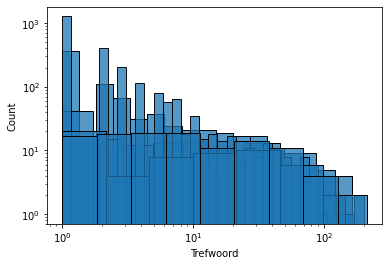

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

for cat in cat_ref_dist:
    ax = sns.histplot(cat_ref_dist[cat], log_scale=(True, True))
    plt.xlabel(cat)


In [14]:
import pandas as pd

cat_list = []
ref_list = []
for cat in cat_ref_dist:
    for num_refs in cat_ref_dist[cat]:
        cat_list.append(cat)
        ref_list.append(num_refs)
        
print(len(cat_list))

df = pd.DataFrame(data={'Category': cat_list, 'Num_refs': ref_list})

df
#sns.histplot(df, x='Num_refs', hue='Category', log_scale=True, multiple="dodge")

3499


,Category,Num_refs
0,Overig,1
1,Overig,23
2,Overig,8
3,Overig,104
4,Overig,2
...,...,...
3494,Trefwoord,5
3495,Trefwoord,6
3496,Trefwoord,7
3497,Trefwoord,2


In [15]:
import numpy as np

for cat in cat_ref_dist:
    ar = np.array(cat_ref_dist[cat])
    print(cat, ar.mean(), np.median(ar))


Overig 24.649350649350648 11.0
Geografische naam 6.429708222811671 2.0
Functie 7.980392156862745 2.0
Persoonsnaam 4.303258145363409 1.0
Instituut 22.25423728813559 8.0
Trefwoord 16.283185840707965 7.0


In [27]:
from collections import Counter

cat_dist = defaultdict(list)

for cat in cat_ref_dist:
    num_refs_freq = Counter(cat_ref_dist[cat])
    total = len(cat_ref_dist[cat])
    cumu_freq = 0
    cumu_links = 0
    for num_refs in range(1,10):
        freq = num_refs_freq[num_refs]
        num_links = (num_refs * (num_refs-1)) / 2 * freq
        cumu_freq += freq
        cumu_links += num_links
        print(f"{cat: <30}{total: >6}{num_refs: >4}{freq: >6}\t{freq / total: >.2f}\t{cumu_freq / total: >.2f}\t{num_links: >8}\t{cumu_links: >8}")
        cat_dist[cat].append(freq / total)
    cumu_freq = 0
    for num_refs in range(10,1100):
        freq = num_refs_freq[num_refs]
        num_links = (num_refs * (num_refs-1)) / 2 * freq
        cumu_freq += freq
    cat_dist[cat].append(cumu_freq / total)
    #for num_refs, freq in num_refs_freq.most_common(10):
    #    print(f"{cat: <30}{num_refs: >4}{freq: >6}\t{freq / total: >.2f}")

df = pd.DataFrame(data=cat_dist)

Overig                            77   1    13	0.17	0.17	     0.0	     0.0
Overig                            77   2     5	0.06	0.23	     5.0	     5.0
Overig                            77   3     4	0.05	0.29	    12.0	    17.0
Overig                            77   4     2	0.03	0.31	    12.0	    29.0
Overig                            77   5     1	0.01	0.32	    10.0	    39.0
Overig                            77   6     2	0.03	0.35	    30.0	    69.0
Overig                            77   7     2	0.03	0.38	    42.0	   111.0
Overig                            77   8     4	0.05	0.43	   112.0	   223.0
Overig                            77   9     2	0.03	0.45	    72.0	   295.0
Geografische naam                754   1   361	0.48	0.48	     0.0	     0.0
Geografische naam                754   2   111	0.15	0.63	   111.0	   111.0
Geografische naam                754   3    67	0.09	0.71	   201.0	   312.0
Geografische naam                754   4    31	0.04	0.76	   186.0	   498.0
Geografische naam        

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10+']


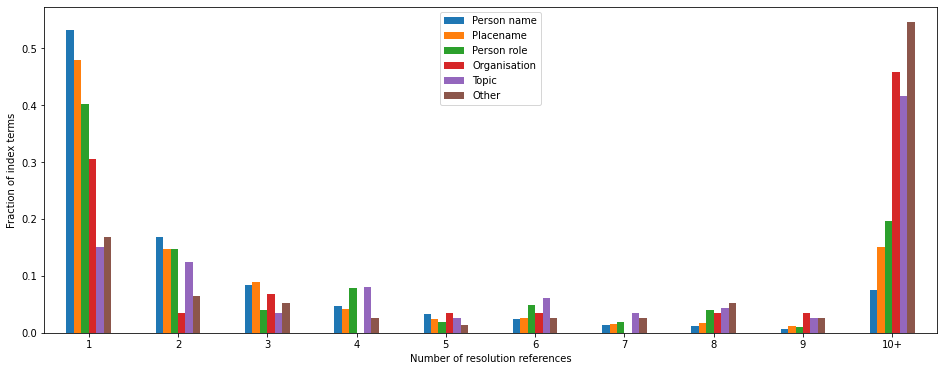

In [28]:
import matplotlib.pyplot as plt
import os

order = {
    'Persoonsnaam': 'Person name', 
    'Geografische naam': 'Placename', 
    'Functie': 'Person role', 
    'Instituut': 'Organisation',
    'Trefwoord': 'Topic',
    'Overig': 'Other'
}

temp_df = df.rename(columns=order)

ax = temp_df[order.values()].plot(kind='bar', rot=0, figsize=(16,6))

labels = [str(i) for i in range(1,11)]
labels[9] = '10+'
print(labels)
ax.xaxis.set_ticklabels(labels)
plt.xlabel('Number of resolution references')
plt.ylabel('Fraction of index terms')

#fig = ax.get_figure()
image_dir = '/Users/marijnkoolen/writing/Humanities-Cluster/Papers/2021/JOCCH-2021-Republic/Images/'
#filename = os.path.join(image_dir, 'index_term_reference_dist.png')
#plt.savefig(filename,  bbox_inches="tight")


['1', '2', '3', '4', '5', '6', '7', '8', '9', '10+']


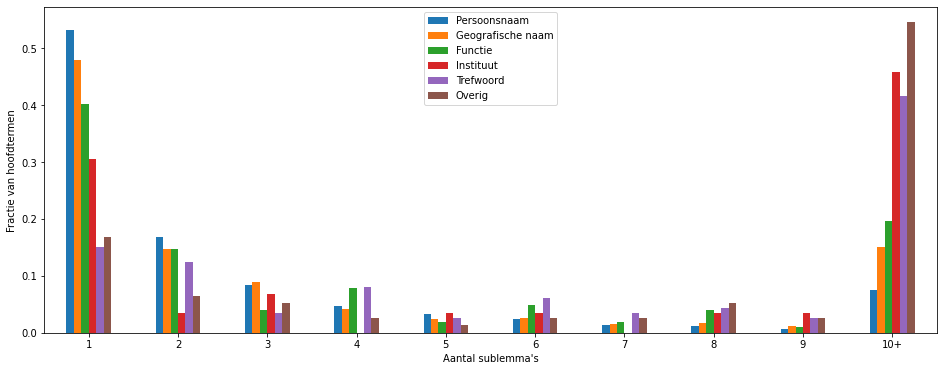

In [29]:
import matplotlib.pyplot as plt
import os

order = {
    'Persoonsnaam': 'Person name', 
    'Geografische naam': 'Placename', 
    'Functie': 'Person role', 
    'Instituut': 'Organisation',
    'Trefwoord': 'Topic',
    'Overig': 'Other'
}

temp_df = df#.rename(columns=order)

ax = temp_df[order.keys()].plot(kind='bar', rot=0, figsize=(16,6))

labels = [str(i) for i in range(1,11)]
labels[9] = '10+'
print(labels)
ax.xaxis.set_ticklabels(labels)
plt.xlabel('Number of resolution references')
plt.ylabel('Fraction of index terms')

#fig = ax.get_figure()
image_dir = '/Users/marijnkoolen/writing/Humanities-Cluster/Papers/2021/JOCCH-2021-Republic/Images/'
#filename = os.path.join(image_dir, 'index_term_reference_dist.png')
#plt.savefig(filename,  bbox_inches="tight")

plt.xlabel("Aantal sublemma's")
plt.ylabel('Fractie van hoofdtermen')

#fig = ax.get_figure()
image_dir = '/Users/marijnkoolen/writing/Humanities-Cluster/Papers/2022/Goetgevonden-March-2022/images/indices'
filename = os.path.join(image_dir, 'index_term_reference_relative_dist.png')
plt.savefig(filename,  bbox_inches="tight")


In [18]:
from collections import Counter

cat_dist = defaultdict(list)

for cat in cat_ref_dist:
    num_refs_freq = Counter(cat_ref_dist[cat])
    total = len(cat_ref_dist[cat])
    cumu_freq = 0
    cumu_links = 0
    for num_refs in range(1,10):
        freq = num_refs_freq[num_refs]
        num_links = (num_refs * (num_refs-1)) / 2 * freq
        cumu_freq += freq
        cumu_links += num_links
        cat_dist[cat].append(freq)
    cumu_freq = 0
    for num_refs in range(10,1100):
        freq = num_refs_freq[num_refs]
        num_links = (num_refs * (num_refs-1)) / 2 * freq
        cumu_freq += freq
    cat_dist[cat].append(cumu_freq)
    #for num_refs, freq in num_refs_freq.most_common(10):
    #    print(f"{cat: <30}{num_refs: >4}{freq: >6}\t{freq / total: >.2f}")

df = pd.DataFrame(data=cat_dist)
df

,Overig,Geografische naam,Functie,Persoonsnaam,Instituut,Trefwoord
0,13,361,41,1272,18,17
1,5,111,15,404,2,14
2,4,67,4,201,4,4
3,2,31,8,114,0,9
4,1,18,2,81,2,3
5,2,20,5,58,2,7
6,2,11,2,34,0,4
7,4,13,4,30,2,5
8,2,9,1,18,2,3
9,42,113,20,182,27,47


['1', '2', '3', '4', '5', '6', '7', '8', '9', '10+']


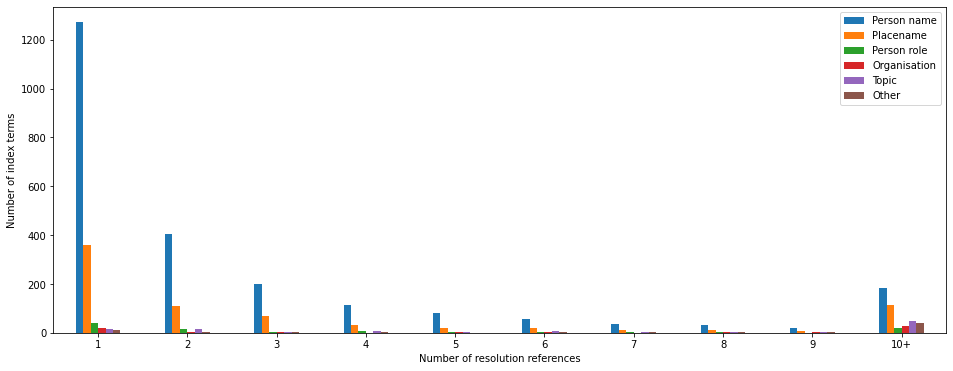

In [24]:
import matplotlib.pyplot as plt
import os

order = {
    'Persoonsnaam': 'Person name', 
    'Geografische naam': 'Placename', 
    'Functie': 'Person role', 
    'Instituut': 'Organisation',
    'Trefwoord': 'Topic',
    'Overig': 'Other'
}

temp_df = df.rename(columns=order)

ax = temp_df[order.values()].plot(kind='bar', rot=0, figsize=(16,6))

labels = [str(i) for i in range(1,11)]
labels[9] = '10+'
print(labels)
ax.xaxis.set_ticklabels(labels)
plt.xlabel('Number of resolution references')
plt.ylabel('Number of index terms')

#fig = ax.get_figure()
image_dir = '/Users/marijnkoolen/writing/Humanities-Cluster/Papers/2021/JOCCH-2021-Republic/Images/'
filename = os.path.join(image_dir, 'index_term_reference_absolute_dist.png')
plt.savefig(filename,  bbox_inches="tight")



['1', '2', '3', '4', '5', '6', '7', '8', '9', '10+']


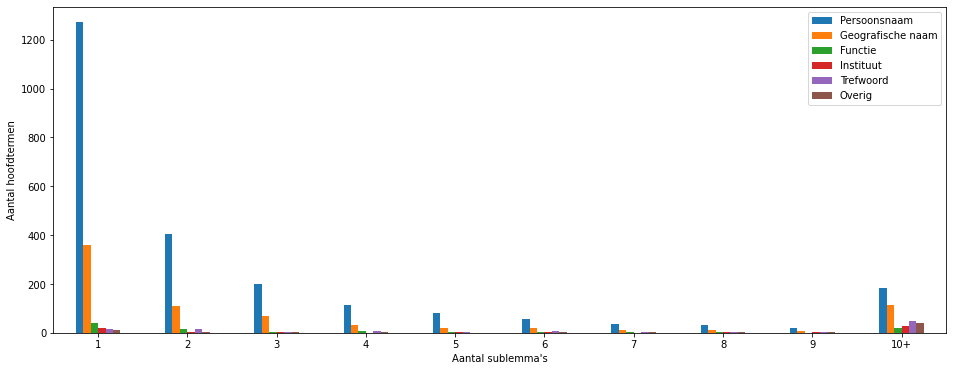

In [25]:
import matplotlib.pyplot as plt
import os

order = {
    'Persoonsnaam': 'Person name', 
    'Geografische naam': 'Placename', 
    'Functie': 'Person role', 
    'Instituut': 'Organisation',
    'Trefwoord': 'Topic',
    'Overig': 'Other'
}

temp_df = df#.rename(columns=order)

ax = temp_df[order.keys()].plot(kind='bar', rot=0, figsize=(16,6))

labels = [str(i) for i in range(1,11)]
labels[9] = '10+'
print(labels)
ax.xaxis.set_ticklabels(labels)
plt.xlabel("Aantal sublemma's")
plt.ylabel('Aantal hoofdtermen')

#fig = ax.get_figure()
image_dir = '/Users/marijnkoolen/writing/Humanities-Cluster/Papers/2022/Goetgevonden-March-2022/images/'
filename = os.path.join(image_dir, 'index_term_reference_absolute_dist.png')
plt.savefig(filename,  bbox_inches="tight")
